In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
#load data
df = pd.read_csv('Sample_Superstore.csv', encoding='ISO-8859-1')

In [ ]:
df.head()

In [ ]:
df

In [ ]:
df.info()

In [ ]:
df.columns


In [29]:
#convert order date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

df = df.sort_values('Order Date')

In [30]:
#set order date as index
df.set_index('Order Date', inplace=True)

In [32]:
#agg sales by month
monthly_sales = df['Sales'].resample('MS').sum()
monthly_sales.head()

Order Date
2014-01-01    14236.895
2014-02-01     4519.892
2014-03-01    55691.009
2014-04-01    28295.345
2014-05-01    23648.287
Freq: MS, Name: Sales, dtype: float64

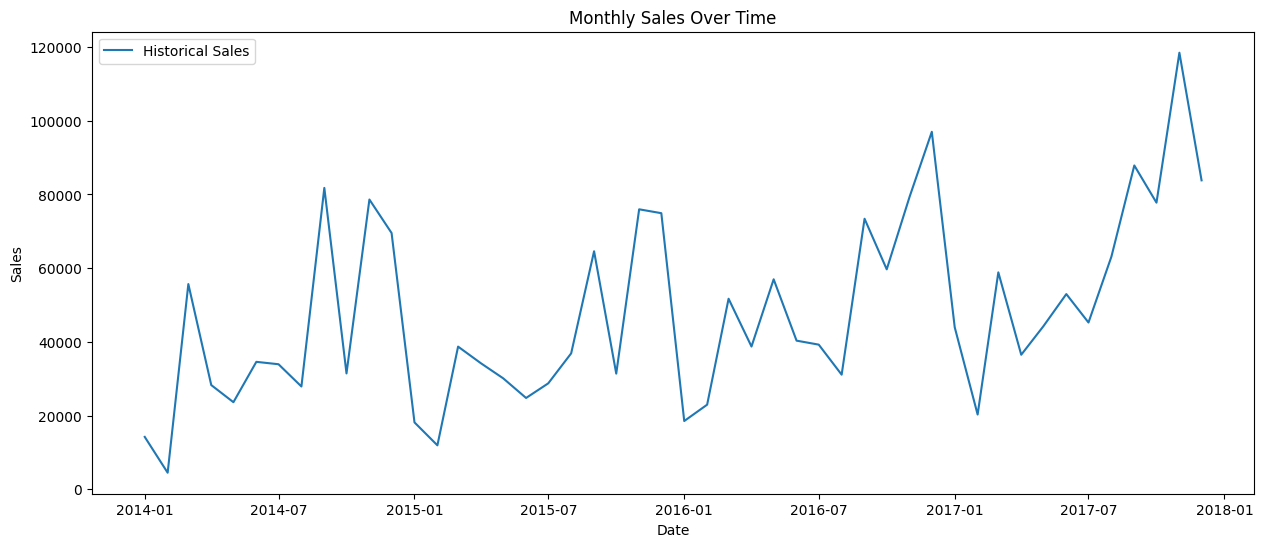

In [35]:
#visualization of historical data
plt.figure(figsize=(15,6))
plt.plot(monthly_sales,label='Historical Sales')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show(  )

In [33]:
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()

In [ ]:
daily_sales = daily_sales.set_index('Order Date')

In [ ]:
daily_sales.head()

In [ ]:
daily_sales['Year'] = daily_sales.index.year
daily_sales['Month'] = daily_sales.index.month
daily_sales['Day'] = daily_sales.index.day
daily_sales['DayOfWeek'] = daily_sales.index.dayofweek

In [ ]:
daily_sales['Lag_1'] = daily_sales['Sales'].shift(1)
daily_sales['Lag_7'] = daily_sales['Sales'].shift(7)
daily_sales['Lag_30'] = daily_sales['Sales'].shift(30)


In [ ]:
daily_sales['Rolling_mean_30'] = daily_sales['Sales'].rolling(window = 30).mean()

daily_sales = daily_sales.dropna()

daily_sales.head()

In [ ]:
train_size = int(len(daily_sales) * 0.8) #define the split point (Train on the firsg )

train = daily_sales.iloc[:train_size]
test = daily_sales.iloc[train_size:]



In [ ]:
features = ['Year', 'Month', 'Day', 'DayOfWeek', 'Lag_1', 'Lag_7', 'Rolling_mean_30']
target = 'Sales'

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

In [ ]:
#model prediction using train test split
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)

mae


In [ ]:
from matplotlib import pyplot as plt

In [ ]:
plt.figure(figsize=(15,6))

#actual sales
plt.plot(test.index,
         y_test,
         label='Actual Sales',
         color ='black',
         alpha = 0.6)


#predicted sales
plt.plot(test.index,
         predictions,
         label = 'Predicted sales',
         color = 'Yellow',
         linewidth= 1)

plt.title('Superstore sales forecast: Actusl vs Predicted', fontsize = 16)
plt.xlabel('Date', fontsize= 12)
plt.ylabel('Sales', fontsize = 12)
plt.legend()
plt.grid(True, alpha = 0.3)
plt.show()

In [ ]:
feature_importances = pd.Series(model.feature_importances_, index=features)


plt.figure(figsize=(10, 6))
feature_importances.sort_values().plot(kind='barh', color='green')
plt.title('What Drives Sales? (Feature Importance)')
plt.show()

In [36]:
# model development(using holt-winters)
train_data = monthly_sales[:-12]
test_data = monthly_sales[-12:]

In [38]:
#fit the model
seasonal_periods = 12
model = ExponentialSmoothing(monthly_sales, seasonal='add', seasonal_periods=seasonal_periods, trend='add').fit()


In [39]:
#forecast on test data
test_predictions = model.forecast(12)

In [40]:
#evaluate
mae = mean_absolute_error(test_data, test_predictions)
rmse = np.sqrt(mean_squared_error(test_data, test_predictions))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 14281.55
RMSE: 16868.93


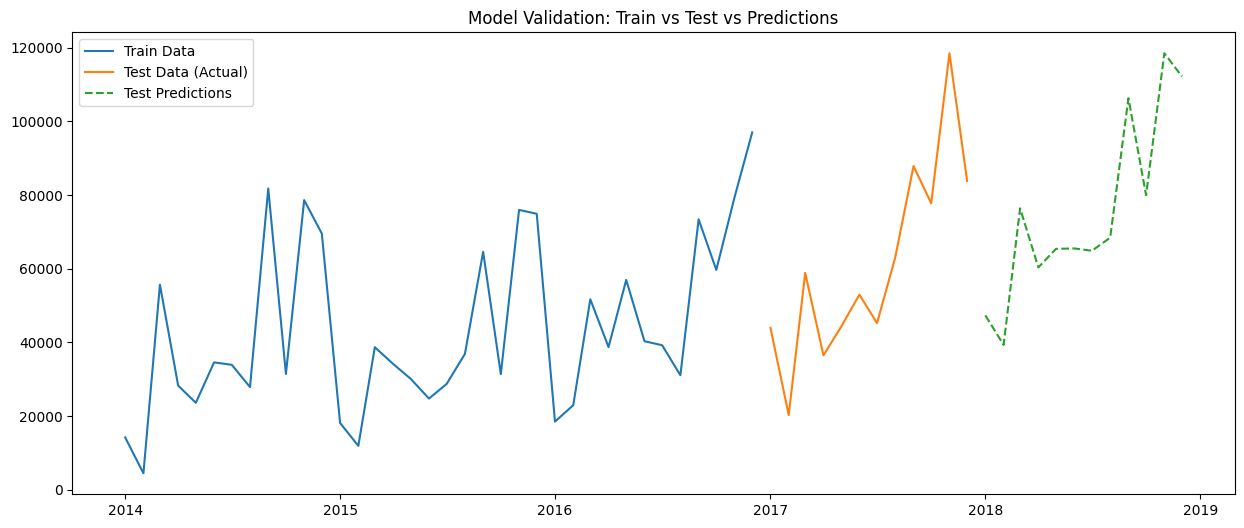

In [41]:
plt.figure(figsize=(15, 6))
plt.plot(train_data, label='Train Data')
plt.plot(test_data, label='Test Data (Actual)')
plt.plot(test_predictions, label='Test Predictions', linestyle='--')
plt.title('Model Validation: Train vs Test vs Predictions')
plt.legend()
plt.show()

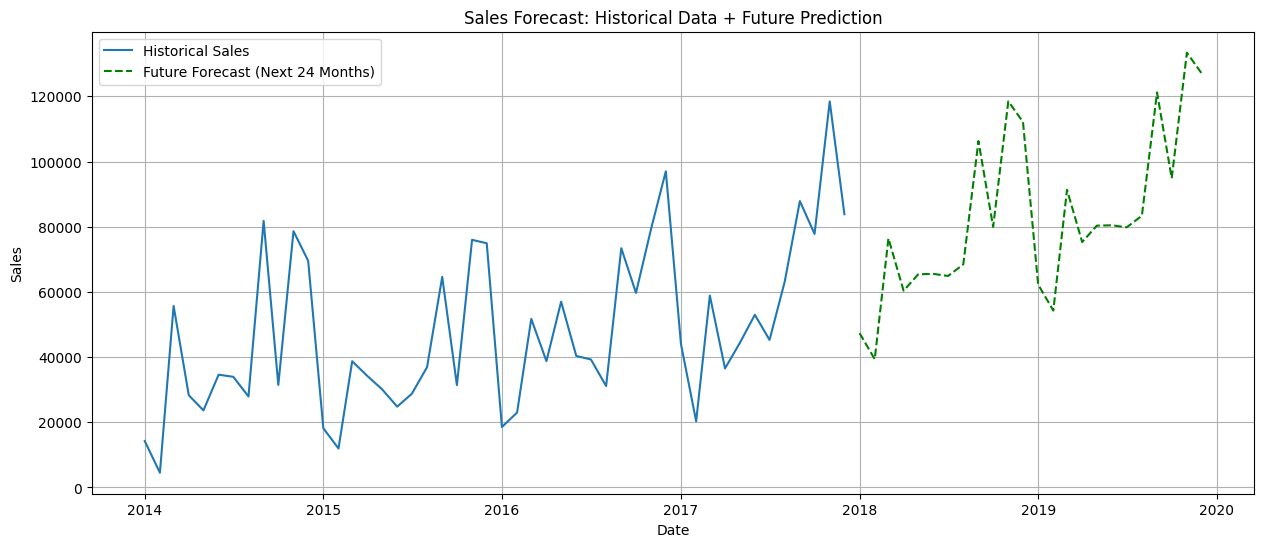

In [42]:
#future forecast
final_model = ExponentialSmoothing(monthly_sales, seasonal='add', seasonal_periods=12, trend='add').fit()
future_forecast = final_model.forecast(24)

plt.figure(figsize=(15, 6))
plt.plot(monthly_sales, label='Historical Sales')
plt.plot(future_forecast, label='Future Forecast (Next 24 Months)', linestyle='--', color='green')
plt.title('Sales Forecast: Historical Data + Future Prediction')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()